# Laminate parameter identification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

## Stress and strain

Let's take a look at laminates in a two-dimensional domain, i.e. the strain is given by
$$ 
\bm{\varepsilon}
= 
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
$$

and the stress is given by 

$$ 
\bm{\sigma}
= 
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}.
$$

## Compliance and stiffness
A single 2D ply compliance tensor is given as 


$$
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
=
\begin{pmatrix}
    \frac{1}{E_{xx}} & -\frac{\nu_{xy}}{E_{xx}} & 0\\
    -\frac{\nu_{yx}}{E_{yy}} & \frac{1}{E_{yy}} & 0\\
    0 & 0 & \frac{1}{G_{xy}}
\end{pmatrix}
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
$$
or as stiffness tensor 
$$
\begin{pmatrix}
    \sigma_{xx}\\
    \sigma_{yy}\\
    \sigma_{xy}
\end{pmatrix}
=
\begin{pmatrix}
    \frac{E_{xx}}{1-\nu_{xy}\nu_{yx}} & \frac{\nu_{xy}E_{yy}}{1-\nu_{xy}\nu_{yx}} & 0\\
    \frac{\nu_{yx}E_{xx}}{1-\nu_{xy}\nu_{yx}}& \frac{E_{yy}}{1-\nu_{xy}\nu_{yx}} & 0\\
    0 & 0 & G_{xy}
\end{pmatrix}
\begin{pmatrix}
    \varepsilon_{xx}\\
    \varepsilon_{yy}\\
    2\varepsilon_{xy}
\end{pmatrix}
$$

The stiffness is characterized by four properties $E_{xx}, E_{yy}, G_{xy}, \nu_{xy}$. The tensor is symmetric with 
$$ \frac{\nu_{xy}}{E_{xx}}=\frac{\nu_{yx}}{E_{yy}} $$

In [2]:
def C(E_xx, E_yy, G_xy, nu_xy):
    """Stiffness tensor"""
    nu_yx = E_yy / E_xx * nu_xy
    return np.array(
        [
            [E_xx / (1 - nu_xy * nu_yx), nu_xy * E_yy / (1 - nu_xy * nu_yx), 0],
            [nu_yx * E_xx / (1 - nu_xy * nu_yx), E_yy / (1 - nu_xy * nu_yx), 0],
            [0, 0, G_xy],
        ]
    )


def S(E_xx, E_yy, G_xy, nu_xy):
    """Compliance tensor"""
    nu_yx = E_yy / E_xx * nu_xy
    return np.array(
        [[1 / E_xx, -nu_xy / E_xx, 0], [-nu_yx / E_yy, 1 / E_yy, 0], [0, 0, 1 / G_xy]]
    )

## Rotation matrix
In the reduced stiffness notation, the roation matrix is given as 

$$
\bm{R} (\phi)
=
\begin{pmatrix}
    \cos^2{\phi} & \sin^2{\phi} & 2\sin{\phi}\cos{\phi}\\
    \sin^2{\phi} & \cos^2{\phi} & -2\sin{\phi}\cos{\phi}\\
    -\sin{\phi}\cos{\phi} & \sin{\phi}\cos{\phi} & \cos^2{\phi}-\sin^2{\phi}
\end{pmatrix}
$$

Note that this matrix is not symmetrical due to the convention of writing $\gamma_{xy}=2\varepsilon_{xy}$ for the shear stress. This is rooted in the defintion of the shear modulus $\sigma_{xy}=G\gamma_{xy}$.

In [3]:
def R(phi):
    """Rotation tensor for angle phi"""
    return np.array(
        [
            [np.cos(phi) ** 2, np.sin(phi) ** 2, 2 * np.sin(phi) * np.cos(phi)],
            [np.sin(phi) ** 2, np.cos(phi) ** 2, -2 * np.sin(phi) * np.cos(phi)],
            [
                -np.sin(phi) * np.cos(phi),
                np.sin(phi) * np.cos(phi),
                np.cos(phi) ** 2 - np.sin(phi) ** 2,
            ],
        ]
    )

## Effective laminate stiffness
The stiffness of multiple plies is computed under the assumption that they experience identical strains (Voigt homogenization). With this approximation, the effective stiffness of $N$ plies with identical thickness and different rotations $\phi_i$ are
$$
\bm{C}_\textrm{eff} = \frac{1}{N} \sum_1^N \bm{R}(\phi_i) \bm{C} \bm{R}(\phi_i) ^\top
$$

In [4]:
def effective_stiffness(E_xx, E_yy, G_xy, nu_xy, phis):
    """Effective stiffness tensor for a rotated material"""
    C_eff = np.zeros((3, 3))
    N = len(phis)
    for phi in phis:
        C_rot = R(phi) @ C(E_xx, E_yy, G_xy, nu_xy) @ R(phi).T
        C_eff += C_rot
    return C_eff / N

In [5]:
def plot_laminate(C_eff):
    """Plot the effective properties of a laminate"""
    # compute the compliance matrices
    N = 1000
    phi = np.linspace(0, 2 * np.pi, N)

    # Compute rotations of C_eff
    C_eff_rot = np.einsum("ijZ,jk,lkZ->ilZ", R(phi), C_eff, R(phi))

    # Compute the effective compliance matrix for the laminate
    S_eff = np.linalg.inv(np.moveaxis(C_eff_rot, -1, 0))

    # Plots
    fig, ax = plt.subplots(
        nrows=1, ncols=3, subplot_kw={"projection": "polar"}, figsize=(15, 5)
    )

    # Laminate Youngs Modulus
    ax[0].plot(phi, 1 / S_eff[:, 0, 0])
    ax[0].set_title("Young's modulus in GPa")

    # Laminate Shear Modulus
    ax[1].plot(phi, 1 / S_eff[:, 2, 2])
    ax[1].set_title("Shear modulus in GPa")

    # Laminate Poisson's ratio
    ax[2].plot(phi, -S_eff[:, 0, 1] / S_eff[:, 1, 1])
    ax[2].set_title("Poisson's ratio")

    plt.tight_layout()
    plt.show()

## Test forward evaluation

Now, we test the code with test data

Effective stiffness tensor C_eff:
[[51.4119345   6.70300935 -6.25160756]
 [ 6.70300935 26.40550427 -6.25160756]
 [-6.25160756 -6.25160756 16.10285502]]


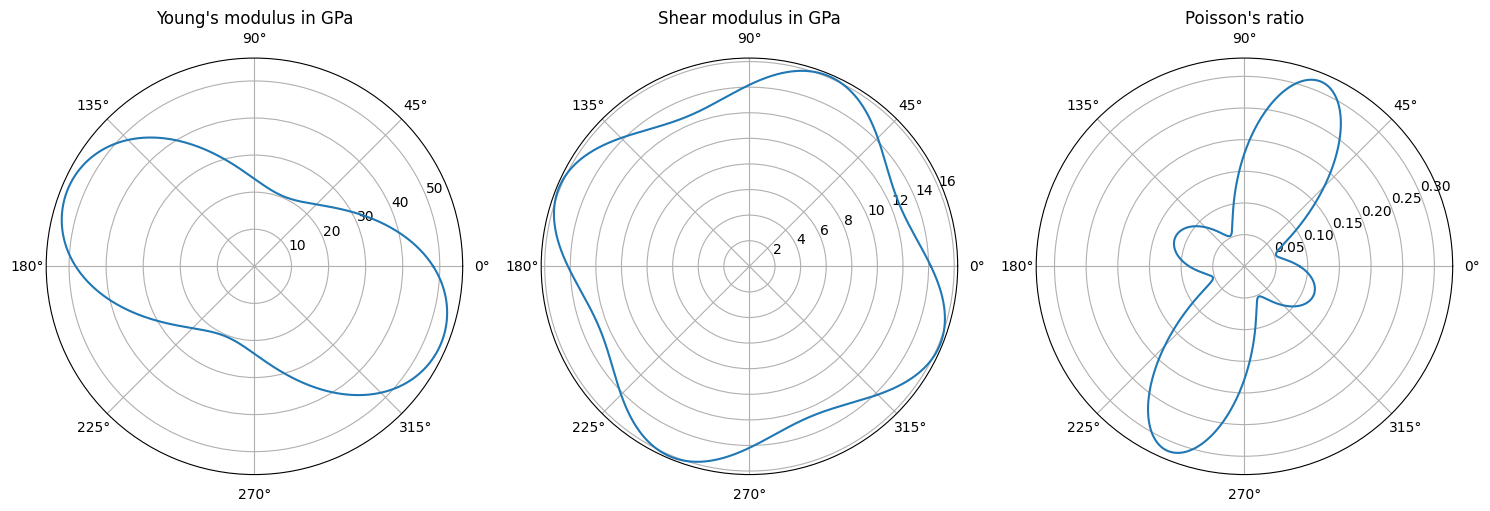

In [6]:
# Test parameters
E_xx = 70.0
E_yy = 20.0
G_xy = 10.0
nu_xy = 0.03

# Laminate ply angles in radians
phis = [0, np.pi / 4]

C_eff = effective_stiffness(E_xx, E_yy, G_xy, nu_xy, phis)

# Print the effective stiffness tensor
print("Effective stiffness tensor C_eff:")
print(C_eff)

# Plot the effective properties of the laminate
plot_laminate(C_eff)

## Inverse problem with data

Given observations of a laminate, we want to minimize the error between a computed stacked laminate of UD layers with $E_{xx}$, $E_{yy}$, $G_{xy}$, and $\nu_{xy}$ and the measured results to find the UD properties yielding the observed response. Therefore, we define a target function 

$$
L(P_j) = \sqrt {\sum_j^M \left(\frac{P_j - \tilde{P_j}}{\tilde{P_j}}\right)^2 }
$$

where $P_j$ denotes a computed property from stacking the laminate and $\tilde{P_j}$ describes a measured observation.

In [7]:
# Biaxial 0-90 Cross Ply Laminate
E090 = 67.687
G090 = 8.925
# Biaxial 0-0-90 Cross Ply Laminate
E0090 = 92.062
# # Biaxial 0-90 Cross Ply Laminate from literature
nu090 = 0.02
nu45 = 0.64


def target_function(x):
    E_xx, E_yy, G_xy, nu_xy = x
    # 0-90 laminate
    C_090 = effective_stiffness(E_xx, E_yy, G_xy, nu_xy, [0, np.pi / 2])
    S_090 = np.linalg.inv(C_090)
    # 0-0-90 laminate
    C_0090 = effective_stiffness(E_xx, E_yy, G_xy, nu_xy, [0, 0, np.pi / 2])
    S_0090 = np.linalg.inv(C_0090)
    C_45 = effective_stiffness(E_xx, E_yy, G_xy, nu_xy, [np.pi / 4, -np.pi / 4])
    S_45 = np.linalg.inv(C_45)
    # Reference data for C/C-SiC from Jonas
    loss = np.sqrt(
        (
            ((1 / S_090[0, 0] - E090) / E090) ** 2
            + ((1 / S_090[2, 2] - G090) / G090) ** 2
            + ((1 / S_0090[0, 0] - E0090) / E0090) ** 2
            + ((-S_090[0, 1] / S_090[1, 1] - nu090) / nu090) ** 2
            + ((-S_45[0, 1] / S_45[1, 1] - nu45) / nu45) ** 2
        )
        / 5
    )
    return loss

Final error: 2.9 %
E_xx: 136.101 GPa
E_yy: 1.442 GPa
G_xy: 8.685 GPa
nu_xy: 0.954


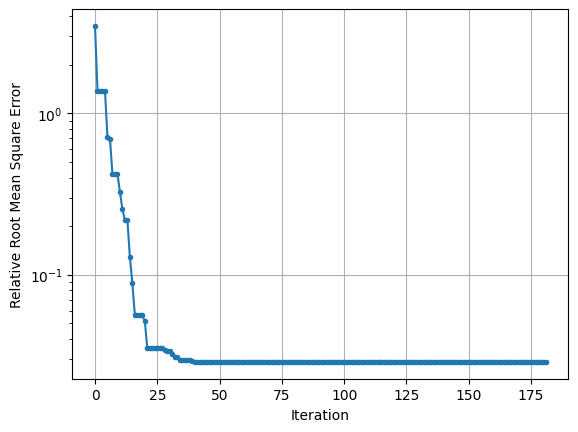

In [8]:
history = []


# Callback to track history
def cb(intermediate_result):
    history.append(intermediate_result.fun)


# Optimization
bounds = [(1, 400), (0.1, 200), (0.1, 200), (-10, 10)]
result = differential_evolution(target_function, bounds, callback=cb, tol=1e-10)

# Optimization history
plt.semilogy(history, ".-")
plt.xlabel("Iteration")
plt.ylabel("Relative Root Mean Square Error")
plt.grid()

# Results
opt = result.x
print(f"Final error: {100*result.fun:.1f} %")
print(f"E_xx: {opt[0]:.3f} GPa")
print(f"E_yy: {opt[1]:.3f} GPa")
print(f"G_xy: {opt[2]:.3f} GPa")
print(f"nu_xy: {opt[3]:.3f}")

## Visualization of data fit 

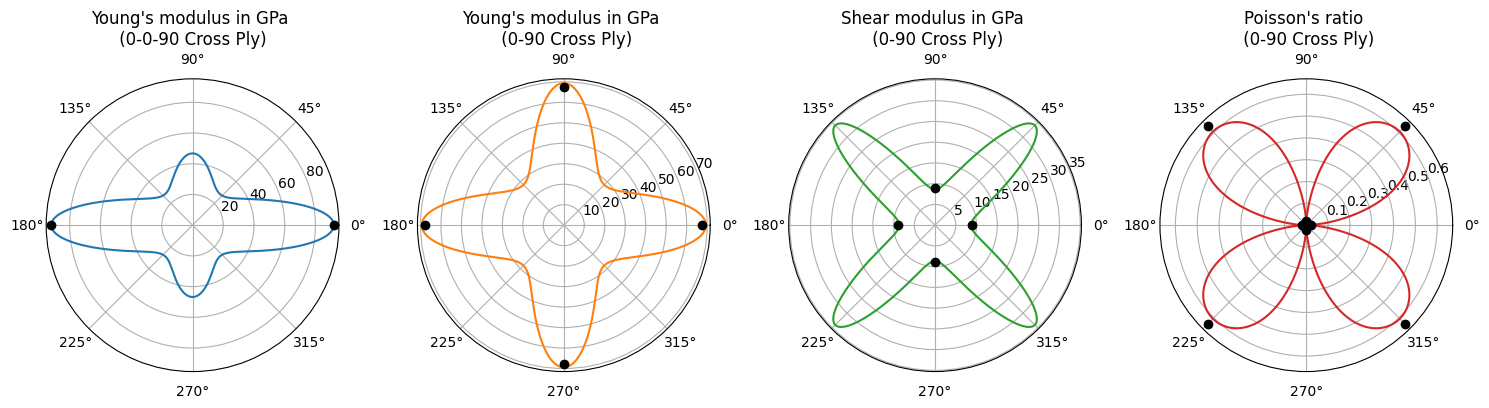

In [ ]:
# compute the compliance matrices
N = 1000
phi = np.linspace(0, 2 * np.pi, N)
offset = np.pi / 2

# 0-90 Cross Ply Laminate
C_eff_0_90 = effective_stiffness(*opt, [0, np.pi / 2])
C_eff_rot_0_90 = np.einsum("ijZ,jk,lkZ->ilZ", R(phi), C_eff_0_90, R(phi))
Srot_0_90 = np.linalg.inv(np.moveaxis(C_eff_rot_0_90, -1, 0))

# 0-0-90 Cross Ply Laminate
C_eff_0_0_90 = effective_stiffness(*opt, [0, 0, np.pi / 2])
C_eff_rot_0_0_90 = np.einsum("ijZ,jk,lkZ->ilZ", R(phi), C_eff_0_0_90, R(phi))
Srot_0_0_90 = np.linalg.inv(np.moveaxis(C_eff_rot_0_0_90, -1, 0))

# Plots
fig, ax = plt.subplots(
    nrows=1, ncols=4, subplot_kw={"projection": "polar"}, figsize=(15, 5)
)

# 0-0-90 Cross Ply Laminate Youngs Modulus
ax[0].plot(phi, 1 / Srot_0_0_90[:, 0, 0], color="tab:blue")
ax[0].plot([0, np.pi], [E0090, E0090], "ok")
ax[0].set_title("Young's modulus in GPa \n (0-0-90 Cross Ply) ")

# 0-90 Cross Ply Laminate Youngs Modulus

ax[1].plot(phi, 1 / Srot_0_90[:, 0, 0], color="tab:orange")
ax[1].plot(
    [0, 0.5 * np.pi, np.pi, 1.5 * np.pi],
    [E090, E090, E090, E090],
    "ok",
)
ax[1].set_title("Young's modulus in GPa \n (0-90 Cross Ply)")

# 0-90 Cross Ply Laminate Shear Modulus
ax[2].plot(phi, 1 / Srot_0_90[:, 2, 2], color="tab:green")
ax[2].plot(
    [0, 0.5 * np.pi, np.pi, 1.5 * np.pi],
    [G090, G090, G090, G090],
    "ok",
)
ax[2].set_title("Shear modulus in GPa \n (0-90 Cross Ply)")

# plot poisson ratio
ax[3].plot(phi, -Srot_0_90[:, 0, 1] / Srot_0_90[:, 1, 1], color="tab:red")
ax[3].plot(
    np.pi * np.array([0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]),
    [nu090, nu45, nu090, nu45, nu090, nu45, nu090, nu45],
    "ok",
)
ax[3].set_title("Poisson's ratio \n (0-90 Cross Ply)")

plt.tight_layout()
plt.show()